# Sequencial Recommendations

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import math
import statistics as stat
from scipy.stats import pearsonr
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

In [2]:
# Loading Datasets
ratings = pd.read_csv(r"ml-latest-small/ratings.csv")
movies = pd.read_csv(r"ml-latest-small/movies.csv")
tags = pd.read_csv(r"ml-latest-small/tags.csv")
links = pd.read_csv(r"ml-latest-small/links.csv")

In [3]:
# Dropping the columns from the ratings and Movies which are not that much important
ratings = ratings.drop(columns = ["timestamp"])
movies = movies.drop(columns = ["genres"])

In [4]:
# Takes UserId and creates a User Matrix
def create_userX_matrix(userId):
    userX_matrix = ratings.query('userId == @userId',inplace = False)
    return userX_matrix

# Creates a user subset where one groups by userID which will be taken into consideration for calculating 
# pearson correlation and find out the most similar users.
def user_subset_common_movie(userId):
    userX_matrix = create_userX_matrix(userId)
    users = ratings[ratings['movieId'].isin(userX_matrix['movieId'].tolist())]
    userSubsetGroup = users.groupby(['userId'])
    userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]) and len(x[1]) > 50, reverse=True)
    return userSubsetGroup, userX_matrix

# Function for calculating the Pearson Correlation Function
def pearsonCorr(inputMovies, similarUsersGroup):
    pearsonCorrelationDict = {}
    for name, group in similarUsersGroup:
        group = group.sort_values(by='movieId')
        inputMovies1 = inputMovies.sort_values(by='movieId')
        temp_df = inputMovies1[inputMovies1['movieId'].isin(group['movieId'].tolist())]
        selectedUserTempRatingList = temp_df['rating'].tolist()
        similarUserTempRatingList = group['rating'].tolist()

        simXX = 0
        meanSelectedUserTempRating = stat.mean(selectedUserTempRatingList)
        for i in selectedUserTempRatingList:
            simXX = simXX + pow((i - meanSelectedUserTempRating),2)
        simYY = 0
        meanSimilarUserTempRaning = stat.mean(similarUserTempRatingList)
        for j in similarUserTempRatingList:
            simYY = simYY + pow((j - meanSimilarUserTempRaning),2)
        simXY = 0
        for i, j in zip(selectedUserTempRatingList, similarUserTempRatingList):
            simXY = simXY+ ((i - meanSelectedUserTempRating ) * (j-meanSimilarUserTempRaning))

        if simXX != 0 and simYY != 0:
            pearsonCorrelationDict[name] = simXY/np.sqrt(simXX*simYY)
        else:
            pearsonCorrelationDict[name] = 0                    
    
    maxSimilarUser = dict(sorted(pearsonCorrelationDict.items(), key=lambda item: item[1], reverse= True))
    return maxSimilarUser

In [5]:
# Function for producing Recommendations for the specific User
def produceRec (inputMovies, pearsonCorrelationDict):
    similarityScoreofSimilarUsers_data = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
    similarityScoreofSimilarUsers_data.head()
    similarityScoreofSimilarUsers_data.columns = ['similarityScore']
    similarityScoreofSimilarUsers_data['userId'] = similarityScoreofSimilarUsers_data.index
    similarityScoreofSimilarUsers_data.index = range(len(similarityScoreofSimilarUsers_data))
    topSimilarUsers=similarityScoreofSimilarUsers_data.sort_values(by='similarityScore', ascending=False)
    topSimilarUsersRating = topSimilarUsers.merge(ratings, left_on='userId', right_on='userId', how='inner')
    topSimilarUsersRating.head()
    meanRb = topSimilarUsersRating.groupby('userId').mean()[['rating']]
    meanRb.columns = ['avgRating']
    meanRb['userId'] = meanRb.index
    meanRb.index = range(len(meanRb))
    topSimilarUsersRating = topSimilarUsersRating.merge(meanRb, left_on='userId', right_on='userId', how='inner')
    topSimilarUsersRating['weightedRatingScore'] = topSimilarUsersRating['similarityScore']*(topSimilarUsersRating['rating']-topSimilarUsersRating['avgRating'])
    tempTopSimilarUsersRating = topSimilarUsersRating.groupby('movieId').sum()[['weightedRatingScore']]
    tempTopSimilarUsersRating.columns = ['sum_weightedRatingScore']
    tempTopSimilarUsersRating['movieId'] = tempTopSimilarUsersRating.index
    

    recommendation_data = pd.DataFrame()
    meanRa = inputMovies['rating'].mean()
    recommendation_data['weighted average recommendation score'] = meanRa+(tempTopSimilarUsersRating['sum_weightedRatingScore']/topSimilarUsers['similarityScore'].sum())
    recommendation_data['movieId'] = recommendation_data.index
    recommendation_data = recommendation_data.sort_values(by='weighted average recommendation score', ascending=False)
    recommendation_data.index = [x for x in range(1,len(recommendation_data)+1)]
    recommendation_data = recommendation_data.rename(columns=  {'weighted average recommendation score': 'scores'})
    return recommendation_data

The main agenda is to deal with groups and generate sequential recommendations by performing several iterations. <br>
In this code, specifically 5 Iterations are generated as per asked in the assignment. <br>
Firstly, a random user has been with userId = 15. <br>
Followed by finding the pearson correlation matrix and then finding two other random similar users with userId = 15, userB = 134 & userC = 384.

In [6]:
#UserA = 15 --> Taken Randomly 
userA = 15
userSubsetGroupA, userAMatrix = user_subset_common_movie(userA)
pearsonCorrelationDictA = pearsonCorr(userAMatrix, userSubsetGroupA)
recMovieA = produceRec(userAMatrix, pearsonCorrelationDictA)

In [7]:
userB = 134
userSubsetGroupB, userBMatrix = user_subset_common_movie(userB)
pearsonCorrelationDictB = pearsonCorr(userBMatrix, userSubsetGroupB)
recMovieB = produceRec(userBMatrix, pearsonCorrelationDictB)

userC = 384
userSubsetGroupC, userCMatrix = user_subset_common_movie(userC)
pearsonCorrelationDictC = pearsonCorr(userCMatrix, userSubsetGroupC)
recMovieC = produceRec(userCMatrix, pearsonCorrelationDictC)

First iteration <br>
For the first iteration, we will do the same approach as previous assignment on group recommendation using average and least misery aggregation method. The group recommendation from this stage will be used as a starting point for the next iterations

In [8]:
aL = recMovieA['movieId'].tolist()
bL = recMovieB['movieId'].tolist()
cL = recMovieC['movieId'].tolist()

# Finding out the common movies between UserA, UserB and UserC
commonRecMov = set(aL) & set(bL) & set(cL)

# Fetching the movies from the recommendation List which are found in the common recommendation of the movies
recA = recMovieA[recMovieA['movieId'].isin(commonRecMov)]
recB = recMovieB[recMovieB['movieId'].isin(commonRecMov)]
recC = recMovieC[recMovieC['movieId'].isin(commonRecMov)]

# Averaging the three user's recommendation with averaging method
frames = [recA, recB, recC]
result = pd.concat(frames)
GrAv = result.groupby(['movieId'], as_index= False).mean().sort_values(by='scores', ascending=False)
GrAv.index = [x for x in range(1, len(GrAv)+1)]
GrAv['title'] = GrAv['movieId'].map(movies['title'])

# GrAv = GrAv.rename(columns=  {'ratings': 'average_rating'})
top20Av1 = GrAv.head(20)
list20Av1Mov = top20Av1['movieId'].tolist()
top20Av1
#showing the top 20 reccommended movie for average method                                              

,movieId,scores,title
1,296,4.042479,Virtuosity (1995)
2,318,4.024687,I Love Trouble (1994)
3,356,3.923002,"Age of Innocence, The (1993)"
4,593,3.914601,Cemetery Man (Dellamorte Dellamore) (1994)
5,260,3.888213,Quiz Show (1994)
6,527,3.842689,"Aristocats, The (1970)"
7,110,3.835782,Jupiter's Wife (1994)
8,1196,3.762667,Picture Perfect (1997)
9,1210,3.757107,187 (One Eight Seven) (1997)
10,50,3.724515,Georgia (1995)


In [9]:
# Calculation of the alpha score:- Taking the paper method and few personal modifications
def alpha_score(userARec, userBRec, userCRec, GroupRec):
    
    list20Mov = GroupRec['movieId'].tolist()
    
    # Making three individual lists and finding out the movies that are represent in list20MOv
    userAList = userARec[userARec['movieId'].isin(list20Mov)]['movieId'].tolist()
    userBList = userBRec[userBRec['movieId'].isin(list20Mov)]['movieId'].tolist()
    userCList = userCRec[userCRec['movieId'].isin(list20Mov)]['movieId'].tolist()
        
    # Calculating the satisfaction score for every user
    satUserA = np.sum(GroupRec['scores'])/np.sum(userARec[userARec['movieId'].isin(list20Mov)]['scores'])
    satUserB = np.sum(GroupRec['scores'])/np.sum(userBRec[userBRec['movieId'].isin(list20Mov)]['scores'])
    satUserC = np.sum(GroupRec['scores'])/np.sum(userCRec[userCRec['movieId'].isin(list20Mov)]['scores'])
    satUsersList = [satUserA, satUserB, satUserC]
    
    # Calculating the Group Satisfaction Score
    group_sat = np.mean(satUsersList)
    #group_dis = np.max(satUsersList) - np.min(satUsersList)
    
    # Kendall Tau between the users so as to find out the disagreement among the users  
    # This will help us to understand that how disagreements among the users affect the overall satisfaction
    
    ktAB, p_valAB = kendalltau(userAList, userBList)
    ktBC, p_valBC = kendalltau(userBList, userCList)
    ktAC, p_valAC = kendalltau(userAList, userCList)
    
    # Kendall Tau between the userAList and the list20Mov
    ktAG, p_valAG = kendalltau(userAList, list20Mov)
    ktBG, p_valBG = kendalltau(userBList, list20Mov)
    ktCG, p_valCG = kendalltau(userCList, list20Mov)
    
    # Calculating the means for two scenarios ;- among users, between user individual list and generated movie list
    ktOnlyUsers = np.mean([ktAB, ktBC, ktAC])
    ktOverall = np.mean([ktAG, ktBG, ktCG])
    
    # Difference of the result of two scenarios
    alpha = abs(ktOnlyUsers - ktOverall)
    
    print ("ktAB", ktAB, "ktBC", ktBC, "ktAC", ktAC)
    print ("ktAG", ktAG, "ktBG", ktBG, "ktCG", ktCG)
    #print ("lenA:", userAList, "lenB:", userBList, "lenC:", userCList)
    print(f'User A sat.Score: {satUserA}')
    print(f'User B sat.Score: {satUserB}')
    print(f'User C sat.Score: {satUserC}')
    print(f'Group disagreement (alpha): {alpha}')
    print(f'Group disagreement amoung Users: {ktOnlyUsers}')
    print(f'Group disagreement overall: {ktOverall}')

    return satUserA, satUserB, satUserC, alpha, group_sat

In [10]:
# Checking the top 20 movies
list20Mov = top20Av1['movieId'].tolist()
userAList = recA[recA['movieId'].isin(list20Mov)]['movieId'].tolist()
userAList
recA

,scores,movieId
1,4.255910,318
2,4.200233,356
3,4.100066,260
4,4.086499,527
5,3.943317,1210
...,...,...
9716,3.222640,231
9717,3.217797,355
9718,3.196558,172
9719,3.191631,208


In [11]:
def sequential_hybrid(recAdf, recBdf, recCdf, alpha, prevIter):
    
    #Not considering the movies that have been recommended on the previous iteration
    prevIterMov = prevIter['movieId'].tolist()    
    recAdf = recAdf[~recAdf['movieId'].isin(prevIterMov)]
    recBdf = recBdf[~recBdf['movieId'].isin(prevIterMov)]
    recCdf = recCdf[~recCdf['movieId'].isin(prevIterMov)]
    frames = [recAdf, recBdf, recCdf]

    results = pd.concat(frames)
    GrIterJAv = results.groupby(['movieId'], as_index= False).mean().sort_values(by='scores', ascending=False)
    GrIterJAv['scores'] = GrIterJAv['scores']*(1-alpha)
    GrIterJLM = result.groupby(['movieId'], as_index= False).min().sort_values(by='scores', ascending=False)
    GrIterJLM['scores'] = GrIterJLM['scores']*(alpha)
    
    frames = [GrIterJAv, GrIterJLM]
    comb = pd.concat(frames)
    GrIterJ = comb.groupby(['movieId'], as_index= False).sum().sort_values(by='scores', ascending=False)
    GrIterJ['title'] = GrIterJ['movieId'].map(movies['title'])
    
    
    return recAdf, recBdf, recCdf, GrIterJ

In [12]:
# get satisfaction score of thre previous iteration
satA1, satB1, satC1, alpha1, group_sat1= alpha_score(recA, recB, recC, top20Av1)

ktAB 0.042105263157894736 ktBC 0.3368421052631579 ktAC 0.15789473684210525
ktAG 0.3684210526315789 ktBG 0.2947368421052632 ktCG 0.30526315789473685
User A sat.Score: 0.9803360563812681
User B sat.Score: 0.94974586654542
User C sat.Score: 1.0787156185355187
Group disagreement (alpha): 0.14385964912280708
Group disagreement amoung Users: 0.17894736842105263
Group disagreement overall: 0.3228070175438597


Make new recommendation based on the previous satisfaction score and new users personal recommendation which deletes all movies that have been previously recommended.

In [13]:
# Second Iteration
recA2, recB2, recC2, GRiter2 = sequential_hybrid(recA, recB, recC, alpha1, top20Av1)
GRiter2Top20 = GRiter2.head(20)
GRiter2Top20

,movieId,scores,title
857,1136,3.538427,Selena (1997)
2953,3996,3.538253,Flirting (1991)
892,1200,3.537696,Desperate Measures (1998)
31,32,3.537525,Babe (1995)
959,1270,3.535730,"I Love You, I Love You Not (1996)"
889,1197,3.535213,In the Company of Men (1997)
904,1213,3.531125,"Kiss Me, Guido (1997)"
43,47,3.529168,Mighty Aphrodite (1995)
507,590,3.527703,Cold Comfort Farm (1995)
905,1214,3.525427,Star Maps (1997)


In [14]:
# Third Iteration
satA2, satB2, satC2, alpha2, group_sat2 = alpha_score(recA2, recB2, recC2, GRiter2Top20)
recA3, recB3, recC3, GRiter3 = sequential_hybrid(recA2, recB2, recC2, alpha2, GRiter2Top20)
GRiter3Top20 = GRiter3.head(20)
GRiter3Top20

ktAB -0.22105263157894736 ktBC -0.25263157894736843 ktAC 0.18947368421052632
ktAG 0.052631578947368425 ktBG 0.031578947368421054 ktCG 0.1473684210526316
User A sat.Score: 0.9795780295285493
User B sat.Score: 0.9293225517812772
User C sat.Score: 1.0688605150720174
Group disagreement (alpha): 0.17192982456140352
Group disagreement amoung Users: -0.09473684210526316
Group disagreement overall: 0.07719298245614035


,movieId,scores,title
5,6,3.492218,Sabrina (1995)
611,778,3.491691,Cool Runnings (1993)
417,480,3.490885,Terminal Velocity (1994)
947,1258,3.487428,Boogie Nights (1997)
886,1193,3.487409,Event Horizon (1997)
896,1204,3.487173,Leave It to Beaver (1997)
2966,4011,3.484821,White Oleander (2002)
1285,1732,3.483276,Tales from the Darkside: The Movie (1990)
600,750,3.483138,"Pompatus of Love, The (1996)"
980,1291,3.482808,Titanic (1997)


In [15]:
# Fourth Iteration
satA3, satB3, satC3, alpha3, group_sat3 = alpha_score(recA3, recB3, recC3, GRiter3Top20)
recA4, recB4, recC4, GRiter4 = sequential_hybrid(recA3, recB3, recC3, alpha3, GRiter3Top20)
GRiter4Top20 = GRiter4.head(20)
GRiter4Top20

ktAB 0.06315789473684211 ktBC -0.052631578947368425 ktAC -0.10526315789473685
ktAG 0.042105263157894736 ktBG -0.11578947368421053 ktCG -0.1368421052631579
User A sat.Score: 0.9729876942287755
User B sat.Score: 0.9297296814158197
User C sat.Score: 1.0680099482543073
Group disagreement (alpha): 0.03859649122807018
Group disagreement amoung Users: -0.03157894736842106
Group disagreement overall: -0.07017543859649124


,movieId,scores,title
913,1222,3.507874,Wishmaster (1997)
2351,3147,3.503802,"Tailor of Panama, The (2001)"
6246,48516,3.499278,NaN
1271,1704,3.493648,Edward Scissorhands (1990)
1199,1610,3.493313,Air Bud: Golden Receiver (1998)
122,150,3.493031,Love & Human Remains (1993)
4100,5952,3.490710,Georgy Girl (1966)
954,1265,3.488715,Sliding Doors (1998)
910,1219,3.485308,Seven Years in Tibet (1997)
7289,79132,3.484584,NaN


In [16]:
# Fifth Iteration
satA4, satB4, satC4, alpha4, group_sat4 = alpha_score(recA4, recB4, recC4, GRiter4Top20)
recA5, recB5, recC5, GRiter5 = sequential_hybrid(recA4, recB4, recC4, alpha4, GRiter4Top20)
GRiter5Top20 = GRiter5.head(20)
GRiter5Top20

ktAB 0.052631578947368425 ktBC 0.10526315789473685 ktAC -0.2736842105263158
ktAG 0.12631578947368421 ktBG 0.021052631578947368 ktCG 0.22105263157894736
User A sat.Score: 0.9895845745492499
User B sat.Score: 0.9322137561569473
User C sat.Score: 1.0802389409169266
Group disagreement (alpha): 0.16140350877192983
Group disagreement amoung Users: -0.03859649122807018
Group disagreement overall: 0.12280701754385966


,movieId,scores,title
2239,2997,3.437813,Punchline (1988)
5279,8874,3.436853,The Monkey King (1964)
1231,1653,3.433496,Suspicion (1941)
2020,2716,3.433339,"Fighting Seabees, The (1944)"
511,595,3.433241,Barb Wire (1996)
5785,32587,3.431778,NaN
3531,4878,3.429735,King Solomon's Mines (1985)
2883,3897,3.429346,Z (1969)
1418,1954,3.425868,Hideous Kinky (1998)
2092,2804,3.425456,Butterfly (La lengua de las mariposas) (1999)


In [17]:
satA5, satB5, satC5, alpha5, group_sat5 = alpha_score(recA5, recB5, recC5, GRiter5Top20)

ktAB -0.0736842105263158 ktBC 0.17894736842105263 ktAC -0.15789473684210525
ktAG -0.1473684210526316 ktBG -0.10526315789473685 ktCG 0.5052631578947369
User A sat.Score: 0.9721960152467308
User B sat.Score: 0.9303582348854069
User C sat.Score: 1.0701881373399142
Group disagreement (alpha): 0.10175438596491228
Group disagreement amoung Users: -0.017543859649122806
Group disagreement overall: 0.08421052631578947


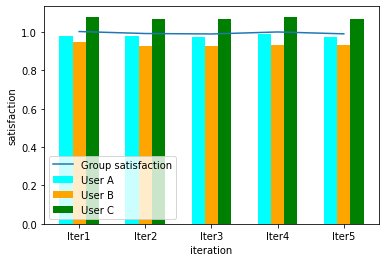

<Figure size 2400x1600 with 0 Axes>

In [18]:
labels = ['Iter1', 'Iter2', 'Iter3', 'Iter4', 'Iter5']
x = np.arange(len(labels))
userASatL = [satA1, satA2, satA3, satA4, satA5]
userBSatL = [satB1, satB2, satB3, satB4, satB5]
userCSatL = [satC1, satC2, satC3, satC4, satC5]
groupSatL = [group_sat1, group_sat2, group_sat3, group_sat4, group_sat5]
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, userASatL, width, color='cyan')
plt.bar(x, userBSatL, width, color='orange')
plt.bar(x+0.2, userCSatL, width, color='green')
plt.plot(labels, groupSatL)
plt.xticks(x, labels)
plt.xlabel("iteration")
plt.ylabel("satisfaction")
plt.legend(["Group satisfaction","User A", "User B", "User C" ])
plt.figure(figsize=(30, 20), dpi=80)
plt.show()

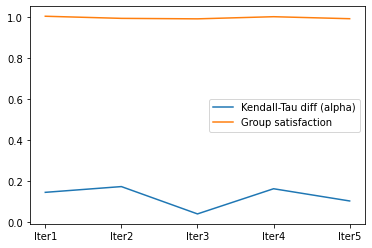

In [19]:
alphas = [alpha1, alpha2, alpha3, alpha4, alpha5]

plt.plot(labels, alphas)
plt.plot(labels, groupSatL)
plt.legend(["Kendall-Tau diff (alpha)","Group satisfaction" ])
plt.show()

In [20]:
# Overall satisfaction of the 3 users
userATotSat = np.sum(userASatL)
userBTotSat = np.sum(userBSatL)
userCTotSat = np.sum(userCSatL)

overalSat = (userATotSat + userBTotSat + userCTotSat)/5
print("Overall user satisfaction from 5 iteration ", overalSat)

Overall user satisfaction from 5 iteration  2.9864131241676253
